In [1]:
#load labels
import os
import json
import cv2
import matplotlib.pyplot as plt
import numpy as np

#gpu
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from sklearn.model_selection import train_test_split

#enable gpu
physical_devices = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], True)


In [2]:

faces = []
imagePaths = []

labelsPath = "data\\labels\\"
labels = os.listdir(labelsPath)

for label in labels:
    with open(labelsPath + label) as f:
        if label.endswith(".vott"):
            continue
        data = json.load(f)
        imagePaths.append(data['asset']['path'].split(":")[-1])
        boundingBoxes = ""
        #check if data has multiple faces
        
        for i in range(len(data['regions'])):            
            if boundingBoxes == "":
                boundingBoxes = [data['regions'][i]['boundingBox']]
            else:
                boundingBoxes.append(data['regions'][i]['boundingBox'])
        #boundingBox = data['regions'][0]['boundingBox']
        faces.append(boundingBoxes)

print(len(faces))
print(len(imagePaths))

1138
1138


In [3]:
""" datapath = "data\\dogFaces\\"
data = os.listdir(datapath)

for i in data:
    if "pixabay" in i or "flickr" in i:
        imagePaths.append(datapath + i)
        imageSize = cv2.imread(datapath + i).shape
        faces.append((0, 0, imageSize[1], imageSize[0]))

print(len(faces))
print(len(imagePaths)) """
     

' datapath = "data\\dogFaces\\"\ndata = os.listdir(datapath)\n\nfor i in data:\n    if "pixabay" in i or "flickr" in i:\n        imagePaths.append(datapath + i)\n        imageSize = cv2.imread(datapath + i).shape\n        faces.append((0, 0, imageSize[1], imageSize[0]))\n\nprint(len(faces))\nprint(len(imagePaths)) '

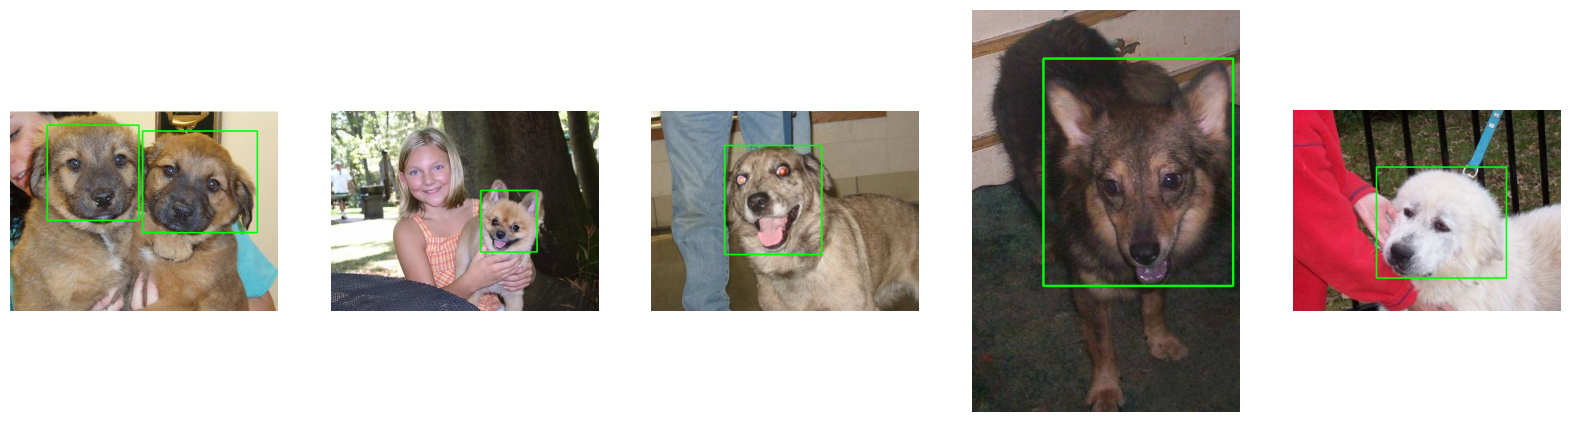

In [4]:
fig, ax = plt.subplots(1,5, figsize=(20,20))
for i in range(5):
    image = cv2.imread(imagePaths[i])
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    for j in range(len(faces[i])):
        coordinates = (faces[i][j]['left'], faces[i][j]['top'], faces[i][j]['width'], faces[i][j]['height'])
        x,y,w,h = coordinates
        topleft = (int(x),int(y))
        bottomright = (int(x)+int(w), int(y)+int(h))
        cv2.rectangle(image, (topleft), (bottomright), (0,255,0), 2) 
    ax[i].imshow(image)
    ax[i].axis("off")
plt.show()


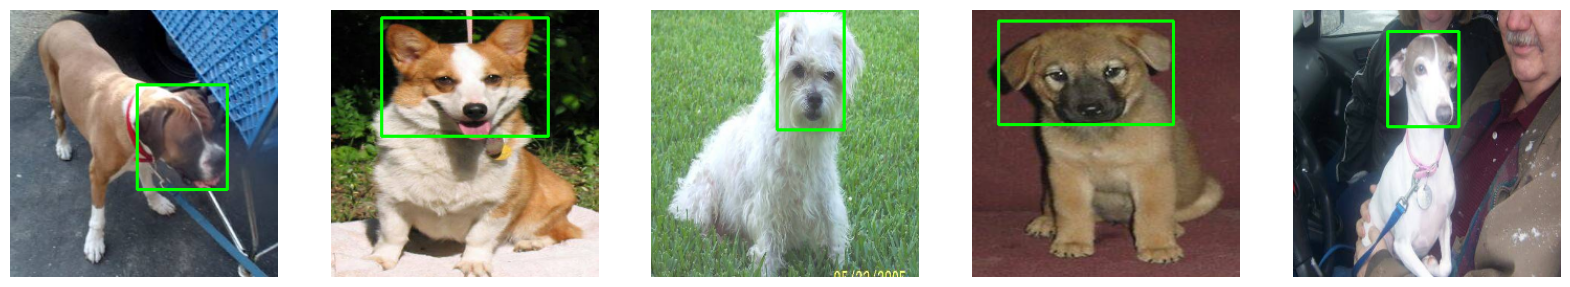

In [5]:
#resize images and bounding boxes
imageSize = 256
resizedImages = []
resizedFaces = []


for i in range(len(imagePaths)):
    image = cv2.imread(imagePaths[i])
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    originalSize = image.shape
    image = cv2.resize(image, (imageSize,imageSize))
    resizedFace = ""
    for j in range(len(faces[i])):
        coordinates = (faces[i][j]['left'], faces[i][j]['top'], faces[i][j]['width'], faces[i][j]['height'])
        x,y,w,h = coordinates
        x = x * (imageSize/originalSize[1])
        y = y * (imageSize/originalSize[0])
        w = w * (imageSize/originalSize[1])
        h = h * (imageSize/originalSize[0])
        if resizedFace == "":
            resizedFace = [{'left':x, 'top':y, 'width':w, 'height':h}]
        else:
            resizedFace.append({'left':x, 'top':y, 'width':w, 'height':h})
    resizedFaces.append(resizedFace)
    resizedImages.append(image)
    
    


fig, ax = plt.subplots(1,5, figsize=(20,20))
for i in range(5):
    i = 1100 + i
    image = resizedImages[i]
    for j in range(len(resizedFaces[i])):
        coordinates = (resizedFaces[i][j]['left'], resizedFaces[i][j]['top'], resizedFaces[i][j]['width'], resizedFaces[i][j]['height'])
        x,y,w,h = coordinates
        topleft = (int(x),int(y))
        bottomright = (int(x)+int(w), int(y)+int(h))
        cv2.rectangle(image, (topleft), (bottomright), (0,255,0), 2) 
    ax[i - 1100].imshow(image)
    ax[i - 1100].axis("off")
plt.show()


In [7]:
#moving data to folder for yolov7

targetTrainPath = "yolov7\\data\\train\\images\\"
targetTrainLabelPath = "yolov7\\data\\train\\labels\\"
targetValPath = "yolov7\\data\\val\\images\\"
targetValLabelPath = "yolov7\\data\\val\\labels\\"


#split data into train and validation
X_train, X_val, y_train, y_val = train_test_split(resizedImages, resizedFaces, test_size=0.2, random_state=42)


#yolo bounding box takes (x_center, y_center, width, height) as input
def convertToYolo(coordinates):
    x,y,w,h = coordinates
    x_center = x + (w/2)
    y_center = y + (h/2)
    return (x_center, y_center, w, h)

def normalizeForYolo(coordinates):
    x,y,w,h = coordinates
    x_center = x / imageSize
    y_center = y / imageSize
    w = w / imageSize
    h = h / imageSize
    return (x_center, y_center, w, h)

for i in range( len(X_train) ):
    cv2.imwrite(targetTrainPath + str(i) + ".jpg", X_train[i])
    with open(targetTrainLabelPath + str(i) + ".txt", "w") as f:
        for j in range(len(y_train[i])):
            coordinates = (y_train[i][j]['left'], y_train[i][j]['top'], y_train[i][j]['width'], y_train[i][j]['height'])
            x_center, y_center, w, h = normalizeForYolo(convertToYolo(coordinates))
            f.write("0 " + str(x_center) + " " + str(y_center) + " " + str(w) + " " + str(h) + "\n")

for i in range( len(X_val) ):
    cv2.imwrite(targetValPath + str(i) + ".jpg", X_val[i])
    with open(targetValLabelPath + str(i) + ".txt", "w") as f:
        for j in range(len(y_val[i])):
            coordinates = (y_val[i][j]['left'], y_val[i][j]['top'], y_val[i][j]['width'], y_val[i][j]['height'])
            x_center, y_center, w, h = normalizeForYolo(convertToYolo(coordinates))
            f.write("0 " + str(x_center) + " " + str(y_center) + " " + str(w) + " " + str(h) + "\n")




In [8]:
#train yolov7 on data
#check cuda via pip

#print path atm
%cd yolov7

#train model
!python train.py --workers 1 --device 0 --batch-size 16 --epochs 250  --img 256 256 --hyp data/hyp.scratch.custom.yaml --name yolov7-custom --weights yolov7.pt

c:\Users\viers\OneDrive\Bureaublad\ResearchProject\SourceCode\FaceDetection\yolov7
wandb: Install Weights & Biases for YOLOR logging with 'pip install wandb' (recommended)

autoanchor: Analyzing anchors... anchors/target = 5.91, Best Possible Recall (BPR) = 1.0000
                 all         228         235      0.0886       0.102      0.0312      0.0058
                 all         228         235      0.0991       0.132      0.0414     0.00747
                 all         228         235       0.336       0.489       0.262      0.0647
                 all         228         235        0.56       0.682       0.615       0.182
                 all         228         235       0.413       0.465       0.352      0.0951
                 all         228         235       0.103       0.217       0.066      0.0168
                 all         228         235       0.114        0.23      0.0607      0.0136
                 all         228         235       0.101        0.22      0.0553    

YOLOR  v0.1-121-g2fdc7f1 torch 1.7.0+cu101 CUDA:0 (GeForce GTX 1650 with Max-Q Design, 4096.0MB)

Namespace(adam=False, artifact_alias='latest', batch_size=16, bbox_interval=-1, bucket='', cache_images=False, cfg='', data='data/coco.yaml', device='0', entity=None, epochs=250, evolve=False, exist_ok=False, freeze=[0], global_rank=-1, hyp='data/hyp.scratch.custom.yaml', image_weights=False, img_size=[256, 256], label_smoothing=0.0, linear_lr=False, local_rank=-1, multi_scale=False, name='yolov7-custom', noautoanchor=False, nosave=False, notest=False, project='runs/train', quad=False, rect=False, resume=False, save_dir='runs\\train\\yolov7-custom', save_period=-1, single_cls=False, sync_bn=False, total_batch_size=16, upload_dataset=False, v5_metric=False, weights='yolov7.pt', workers=1, world_size=1)
tensorboard: Start with 'tensorboard --logdir runs/train', view at http://localhost:6006/
2023-01-10 17:47:04.184687: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfu

In [10]:
#test model
%cd yolov7
!python detect.py --weights runs/train/yolov7-custom/weights/best.pt --img-size 256 --conf 0.4 --source "C:\Users\viers\OneDrive\Bureaublad\ResearchProject\SourceCode\test"

[WinError 2] The system cannot find the file specified: 'yolov7'
c:\Users\viers\OneDrive\Bureaublad\ResearchProject\SourceCode\FaceDetection\yolov7


YOLOR  v0.1-121-g2fdc7f1 torch 1.7.0+cu101 CUDA:0 (GeForce GTX 1650 with Max-Q Design, 4096.0MB)

Model Summary: 306 layers, 36479926 parameters, 6194944 gradients, 103.2 GFLOPS


Namespace(agnostic_nms=False, augment=False, classes=None, conf_thres=0.4, device='', exist_ok=False, img_size=256, iou_thres=0.45, name='exp', no_trace=False, nosave=False, project='runs/detect', save_conf=False, save_txt=False, source='C:\\Users\\viers\\OneDrive\\Bureaublad\\ResearchProject\\SourceCode\\test', update=False, view_img=False, weights=['runs/train/yolov7-custom/weights/best.pt'])
Fusing layers... 
RepConv.fuse_repvgg_block
RepConv.fuse_repvgg_block
RepConv.fuse_repvgg_block
 Convert model to Traced-model... 
 traced_script_module saved! 
 model is traced! 

Done. (113.0ms) Inference, (0.0ms) NMS
 The image with the result is saved in: runs\detect\exp3\ellie.jpg
1 face, Done. (112.0ms) Inference, (5.0ms) NMS
 The image with the result is saved in: runs\detect\exp3\mar.jpg
Done. (113.0ms) Inference, (0.0ms) NMS
 The image with the result is saved in: runs\detect\exp3\notdog.jpg
video 4/4 (1/1185) C:\Users\viers\OneDrive\Bureaublad\ResearchProject\SourceCode\test\testvid.mp

In [11]:
#test model
%cd yolov7
!python detect.py --weights runs/train/yolov7-custom/weights/best.pt --img-size 256 --conf 0.4 --source "C:\Users\viers\OneDrive\Bureaublad\ResearchProject\SourceCode\test2"

[WinError 2] The system cannot find the file specified: 'yolov7'
c:\Users\viers\OneDrive\Bureaublad\ResearchProject\SourceCode\FaceDetection\yolov7
Namespace(agnostic_nms=False, augment=False, classes=None, conf_thres=0.4, device='', exist_ok=False, img_size=256, iou_thres=0.45, name='exp', no_trace=False, nosave=False, project='runs/detect', save_conf=False, save_txt=False, source='C:\\Users\\viers\\OneDrive\\Bureaublad\\ResearchProject\\SourceCode\\test2', update=False, view_img=False, weights=['runs/train/yolov7-custom/weights/best.pt'])
Fusing layers... 
RepConv.fuse_repvgg_block
RepConv.fuse_repvgg_block
RepConv.fuse_repvgg_block
 Convert model to Traced-model... 
 traced_script_module saved! 
 model is traced! 

video 1/1 (1/551) C:\Users\viers\OneDrive\Bureaublad\ResearchProject\SourceCode\test2\325075263_5796202853794759_6987762088005040392_n.mp4: 1 face, Done. (109.0ms) Inference, (9.0ms) NMS
video 1/1 (2/551) C:\Users\viers\OneDrive\Bureaublad\ResearchProject\SourceCode\test2

YOLOR  v0.1-121-g2fdc7f1 torch 1.7.0+cu101 CUDA:0 (GeForce GTX 1650 with Max-Q Design, 4096.0MB)

Model Summary: 306 layers, 36479926 parameters, 6194944 gradients, 103.2 GFLOPS
